## Notes

* $ν > 2$ to have a defined variance

#### <font color=B8860B>t distribution has heavier tails than the normal distribution, and does it assign smaller likelihoods to large deviations?</font>

<font color=orange>the distribution allows for a greater probability of observing values that deviate significantly from the mean, compared to the normal distribution. In the context of residuals or errors, this means that when fitting a model to data with the assumption that the residuals follow a Student's t-distribution, the occasional large residuals (often due to outliers) will not disproportionately affect the fit as much as they would if a normal distribution were assumed. This results in a more robust estimation, less sensitive to outliers. The "smaller likelihoods to large deviations" is a bit of a misnomer – it's not that the likelihoods are smaller, but rather that the impact of large deviations on the likelihood is less severe, allowing the model to accommodate those outliers without being unduly influenced by them.</font>

#### <font color=B8860B>In what case will a student t distribution becomes a Cauchy distribution?<font>

A Student's t-distribution becomes a Cauchy distribution specifically when the degrees of freedom parameter $ \nu $ is equal to 1. The Cauchy distribution, also known as the Lorentz distribution, is a special case of the Student's t-distribution. It has heavier tails and a characteristic peak at the central value, which is why it is often used in situations where there are concerns about outliers or heavy tails in the data.

The probability density function (pdf) of the Student's t-distribution is given by:

$$
f(t|\nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\,\Gamma\left(\frac{\nu}{2}\right)} \left(1+\frac{t^2}{\nu}\right)^{-\frac{\nu+1}{2}}
$$

When $ \nu = 1 $, this simplifies to the pdf of the standard Cauchy distribution:

$$
f(t|1) = \frac{1}{\pi\left(1+t^2\right)}
$$

The Cauchy distribution is known for its undefined mean and variance, regardless of the sample size, due to the heavy tails of its distribution. This property makes it an interesting case study in robust statistics.

# Basic Normalizing Flow Training and Sampling

This notebook is the first in a series of [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl). In this tutorial, we will layout the basic theory behind [Normalizing Flows (NFs)](https://arxiv.org/abs/1505.05770) and how to use the implementations in InvertibleNetworks.jl to train and sample from a basic NF. [The following notebook](https://github.com/slimgroup/SLIMTutorials/blob/main/08_conditional_normalizing_flow.ipynb) in the series demonstrates how to train a conditional normalizing flow. You can also learn the concept and ideology of [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl) package in the [JuliaCon 2021](https://juliacon.org/2021/) presentation with the youtube video [here](https://www.youtube.com/watch?v=9M-zEGHY4i4).

In this tutorial, we train an NF using the [GLOW](https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf) architecture, which implements:
* Affine couplying layer from [Real-NVP](https://arxiv.org/abs/1605.08803)
* Ability to activate multiscale for efficient training and compressive behavior in latent $z$ 
* ActNorms for stable training   
* 1x1 Convolutions for channel mixing between affine couplying layers  

In [1]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot #, Plots
using Flux
using Random
using SpecialFunctions
using Distributions

import Flux.Optimise: ADAM, update!

PyPlot.rc("font", family="serif"); 
Random.seed!(1)

TaskLocalRNG()

In [2]:
@which sample_banana

InvertibleNetworks

Change the resulting distribution from normal noise to student's t distribution
$$ p_t(Z, \nu) = \frac{\Gamma((\nu + d) / 2)}{(\nu \pi)^{d/2} \Gamma(\nu / 2)} \left(1 + \frac{Z^2}{\nu}\right)^{-(\nu + d) / 2} $$

### Add outliers

1. Add outliers and see if t-distribution is more robust
1. Flip training data (banana) upside down and see if studentizing flow will ignore them.

In [3]:
n_train = 60000;
X_train = sample_banana(n_train);
n_outliers = floor(Int, n_train*0.05)
# d = Normal()

X1 = rand(Uniform(-5, 5), n_train)
X2 = sin.(X1)   # sinusoidal data
# X2 = 50 .* X1 .^ 2   # parabolic data
X_train = zeros(1, 1, 2, n_train)
X_train[1, 1, 1, :] = X1
X_train[1, 1, 2, :] = X2

println(size(X_train)) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

# add outlier to the data.
outlier = false
if outlier
    for i in 1:n_outliers
        X_train[1, 1, 2, rand(1:n_train)] += rand(Normal(0, 10), 1)[1]
    end
end

(1, 1, 2, 60000)


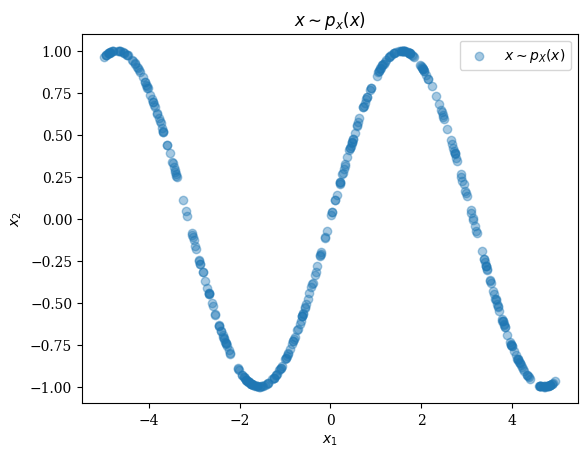

In [4]:
fig = figure(); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

* In this step `back = Flux.Zygote.pullback(() -> log_prob(Z), θ)[2]`, `() -> log_prob(Z)` should have been `() -> $\Gamma$ distribution`. I previously wrote `return (logprob_grad, lgdet, logprob_grad, Z)`. This cannot be right since it does not match the Gaussian case, which is `return (l2_loss, lgdet, dZ)`. `logprob_grad` is the derivative of `l2_loss`.

- [ ] Try take AD on Gaussian case first and verify it recovers the same result as original notebook.
```python
    θ = Flux.params([Z])
    back = Flux.Zygote.pullback(() -> log_prob(Z), θ)[2]
    grad = back(1f0)
    logprob_grad = grad[θ[1]]
```


<font color=B8860B>How is lgdet updated?</font>

`lgdet` is calculated during the forward pass (`Z, lgdet = G.forward(X)`) and returned along with the L2 loss from the loss function.

However, how `lgdet` is used in the gradient update is not explicitly shown in the snippet. <font color=orange>The `backward` function in Flux (or its underlying AD system) would typically handle the inclusion of the `lgdet` term in the gradient computation internally if the model's forward pass is set up correctly to track this dependency. This means that even though we don't see an explicit update step for `lgdet` in the code, its gradients are likely being computed and applied during `G.backward(dZ, Z)` if `lgdet` is part of the computational graph constructed during the forward pass.</font>

If you need to ensure that `lgdet` is correctly influencing the gradient updates, you would want to look into the implementation details of `G.forward` and <font color=orange>make sure that `lgdet` is computed in a way that its dependency on the model parameters is tracked by the automatic differentiation system. If `lgdet` is a differentiable function of the model parameters, then its contribution to the gradients should be automatically accounted for when `backward` is called.</font>

In [5]:
function loss(G, X)
    batch_size = size(X)[end] 
    
    Z, lgdet = G.forward(X)
    
    l2_loss = 0.5*norm(Z)^2 / batch_size  # likelihood under Normal Gaussian training 
    dZ = Z / batch_size                   # gradient under Normal Gaussian training
                                          # gradient of l2_loss with respect to Z
                                          # should have been called dlossdZ instead of dZ
    
    G.backward(dZ, Z)  #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet, dZ)
end

function log_prob(Z)
    likelihood = -0.5*norm(Z)^2   # for sanity check. Recover normalizing flow result.
    
    # cons = loggamma(0.5*(ν+d)) - loggamma(0.5*ν) - 0.5*d*log(pi*ν)
    # # input_norms = utils.sum_except_batch(((Z)^2), num_batch_dims=1)
    # likelihood = cons - 0.5*(ν + d) * log(1 + (1/ν) * norm(Z)^2)
    
    return -likelihood
end

function loss_t(G, X)
    batch_size = size(X)[end]
    
    Z, lgdet = G.forward(X)
    
    function l2_loss(Z)
        return log_prob(Z) / batch_size
    end
    
    # use AD
    θ = Flux.params([Z])
    back = Flux.Zygote.pullback(() -> l2_loss(Z), θ)[2]
    grad = back(1f0)
    logprob_grad = grad[θ[1]]
    
    G.backward(logprob_grad, Z)  # sets gradients of G wrt output and also logdet terms
    
    return (l2_loss(Z), lgdet, logprob_grad, Z)
end

# function loss_t(G, X)
#     batch_size = size(X)[end]
    
#     Z, lgdet = G.forward(X)
    
#     function l2_loss(Z)
#         return log_prob(Z) / batch_size
#     end
    
#     logprob_grad =  0.5*(ν + d) * 1/(1 + (1/ν) * norm(Z)^2) * (1/ν) * 2*Z / batch_size 
    
#     G.backward(logprob_grad, Z)  # sets gradients of G wrt output and also logdet terms
    
#     return (l2_loss(Z), lgdet, logprob_grad, Z)
# end

loss_t (generic function with 1 method)

In [6]:
# Z = 0.1
# println(batch_size)
# l2_loss = log_prob(Z) / batch_size
# θ = Flux.params([Z])
# back = Flux.Zygote.pullback(() -> l2_loss, θ)[2]
# grad = back(1f0)
# logprob_grad = grad[θ[1]]
# G.backward(logprob_grad, Z)

In [7]:
nx          = 1
ny          = 1

# network architecture
n_in        = 2 #put 2d variables into 2 channels
n_hidden    = 16
levels_L    = 1
flowsteps_K = 10
eps = 3

# training parameters
batch_size = 50
maxiter    = cld(n_train, batch_size)

lr = 9f-4
opt = ADAM(lr)

ν = 1e10
# 2-d data throughout this notebook
d = 2

2

In [8]:
function train_flow(G, loss, maxiter, opt)
    loss_l2_list    = zeros(maxiter)
    loss_lgdet_list = zeros(maxiter)

    for ep in 1:eps
        for j = 1:maxiter
            Base.flush(Base.stdout)
            # idx = ((j-1)*batch_size+1) : (j*batch_size)
            idx = rand(1:n_train, batch_size)

            X = X_train[:,:,:,idx]
            #x = x |> gpu

            losses = loss(G, X)
            loss_l2_list[j] = losses[1]
            loss_lgdet_list[j] = losses[2]

            (j%50==0) && println("Iteration=", j, "/", maxiter, 
                "; f likelihood = ", loss_l2_list[j],
                "; f lgdet = ", loss_lgdet_list[j],
                "; f nll objective = ", loss_l2_list[j] - loss_lgdet_list[j])

            for p in get_params(G)
                Flux.Optimise.update!(opt, p.data, p.grad)
            end
        end
    end
    return loss_l2_list, loss_lgdet_list
end

train_flow (generic function with 1 method)

In [9]:
G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;);
# #G = G |> gpu 

loss_l2_list, loss_lgdet_list = train_flow(G, loss, maxiter, opt);

Iteration=50/1200; f likelihood = 0.948257594344491; f lgdet = -0.609237207000345; f nll objective = 1.557494801344836
Iteration=100/1200; f likelihood = 0.9715382213848056; f lgdet = -0.668042673685683; f nll objective = 1.6395808950704887
Iteration=150/1200; f likelihood = 0.9237255218206193; f lgdet = -0.7371439372181301; f nll objective = 1.6608694590387494
Iteration=200/1200; f likelihood = 0.9161715081385744; f lgdet = -0.8609676575032427; f nll objective = 1.7771391656418172
Iteration=250/1200; f likelihood = 0.9474114055766232; f lgdet = -0.6308184424559424; f nll objective = 1.5782298480325656
Iteration=300/1200; f likelihood = 1.0782338407235137; f lgdet = -0.5299826121736091; f nll objective = 1.6082164528971228
Iteration=350/1200; f likelihood = 1.1951990862360342; f lgdet = -0.46817931241729627; f nll objective = 1.6633783986533306
Iteration=400/1200; f likelihood = 1.024771477651234; f lgdet = -0.39820448888903515; f nll objective = 1.4229759665402693
Iteration=450/1200; 

In [10]:
# G_t = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;);
#G = G |> gpu 

# loss_l2_list_t, loss_lgdet_list_t = train_flow(G_t, loss_t, maxiter, opt);

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with [qq plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

In [11]:
gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

# axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

# axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6, label="gaussian"); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

# axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6, label="gaussian"); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update") 

# gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

# fig, axs = subplots(3, 1, sharex=true)
# fig.subplots_adjust(hspace=0)

# axs[1].plot(loss_l2_list_t, color="black", linewidth=0.6); 
# axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
# axs[1].set_ylabel("L2 Norm")
# axs[1].yaxis.set_label_coords(-0.09, 0.5)
# axs[1].legend()

axs[2].plot(loss_lgdet_list_t, color="b", linewidth=0.6, label="t distribution"); 
# axs[2].set_ylabel("Log DET") 
# axs[2].yaxis.set_label_coords(-0.09, 0.5) 
axs[2].legend()

axs[3].plot(loss_l2_list_t .- loss_lgdet_list_t, color="b", linewidth=0.6, label="t distribution"); 
# axs[3].set_ylabel("Full Objective") 
# axs[3].yaxis.set_label_coords(-0.09, 0.5)
# axs[3].set_xlabel("Parameter Update") 
axs[3].legend()

# fig.legend()

LoadError: UndefVarError: `loss_lgdet_list_t` not defined

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ in the simple 2D Rosenbrock distribution, we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$.

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

Let's start by taking samples from $z \sim N(0,I) $

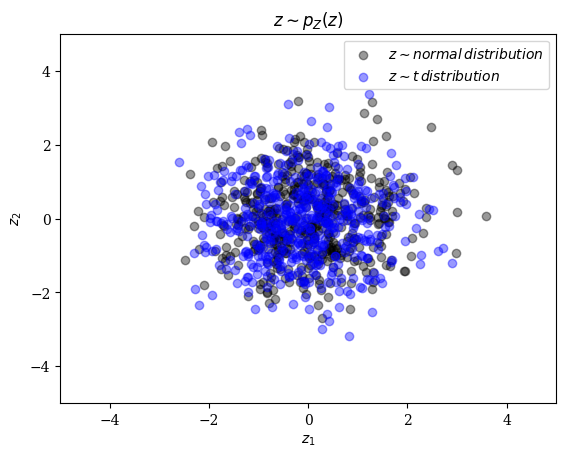

In [12]:
num_test_samples = 500;
Z_test = randn(Float32,nx,ny,n_in, num_test_samples);
t_dist = TDist(ν)
Z_test_t = rand(t_dist, nx, ny, n_in, num_test_samples)

fig, ax = subplots(1, 1); title(L"z \sim p_{Z}(z)")
# ax = fig.add_subplot(111);
ax.scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim normal\, distribution");
ax.scatter(Z_test_t[1,1,1,:], Z_test_t[1,1,2,:]; alpha=0.4, color="b", label = L"z \sim t\, distribution");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
# ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [13]:
X_test = G.inverse(Z_test);
# X_test_t = G_t.inverse(Z_test);

In [14]:
# trans_num = 400
# start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
# end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

# fig = subplots(1, 1, figsize=(10, 10)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");
# # ax = fig.add_subplot(111)

# for line in zip(start_points, end_points)
#     plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
#     scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
#     scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="red")
# end

# start_points = [(Z_test_t[1,1,1,i], Z_test_t[1,1,2,i]) for i in 1:trans_num]
# end_points = [(X_test_t[1,1,1,i], X_test_t[1,1,2,i]) for i in 1:trans_num]

# # for line in zip(start_points, end_points)
# #     plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="blue")
# #     scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="blue")
# #     scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
# # end
# xlabel("First Dimension"); ylabel("Second Dimension");
# # ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

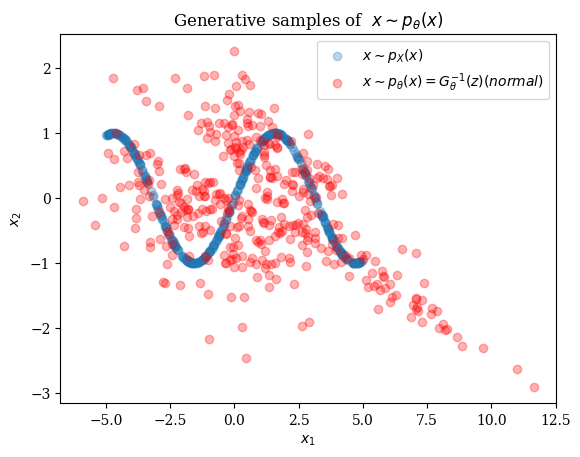

In [15]:
fig = subplots(1, 1); title(L"Generative samples of  $x \sim p_{\theta}(x)$")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.3, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.3, color="red", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z) (normal)");
# scatter(X_test_t[1,1,1,1:400], X_test_t[1,1,2,1:400]; alpha=0.3, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z) (t dist)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

## save figures

# if outlier
#     imgname = "t_flow_ν=$ν" * "_with_outlier.png"
#     savefig("07_plots/$imgname")
# else
#     imgname = "t_flow_ν=$ν.png"
#     savefig("07_plots/$imgname")
# end

In [16]:
@which NetworkGlow

InvertibleNetworks